In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd 
import torch.optim as optim
import os
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset
import torch
from scipy.stats import vonmises
import numpy.fft as fft 
import math
import random
import itertools
import functools
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.linalg import hadamard
from scipy.linalg import inv

In [2]:
import random
import itertools
import functools
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Data Generation
# length: int; length of each binary string
def generateNormalData(length, sampleSize, sd=1):
    # Generates normal distribution over binary survey results.
    # generate all binary strings of given length
    binaryStrings = [''.join(map(str,i)) for i in itertools.product([0,1], repeat=length)]
    meanBucket = random.choice(binaryStrings)
    distances = {i : getDistance(meanBucket, i) for i in binaryStrings}
    samples = {i: 0 for i in binaryStrings} # sample data
    bucket_size = 2 * sd / max(distances.values()) # map buckets from 0 to 2*sd (MAKE THIS A PARAMETER LATER)
    # map each point to their pdf
    pdfs = {i : norm.pdf(distances[i] * bucket_size) for i in binaryStrings}
    # normalise and map each pdf to some value between 0 and 1
    norm_const = sum(pdfs.values()) 
    normalised_cumu = {i : 0 for i in binaryStrings}
    s = 0
    for key in pdfs:
        normalised_pdf = pdfs[key] / norm_const
        normalised_cumu[key] = normalised_pdf + s
        s += normalised_pdf
    # Maps the right end point of each bucket to its corresponding binary string
    cumu_to_bin = {normalised_cumu[i] : i for i in binaryStrings}
    
    # Get samples
    cdf_arr = sorted(list(cumu_to_bin.keys()))
    for n in range(sampleSize):
        roll = random.random()
        # find which bin it fits in first
        # This works because we iterate from smallest to largest bucket
        first_bucket = None
        for bucket in cdf_arr:
            if roll < bucket:
                first_bucket = bucket
                break
        samples[cumu_to_bin[first_bucket]] += 1
    # apply symmetry - NOT YET IMPLEMENTED
    # randomly invert all of the keys.
    random_inversion = random.random()
    if random_inversion < 0.5:
        # swap all the ones and zeros
        #print("swapping")
        #print(samples['1'*length])
        new_samples = {}
        for key in samples:
            new_key = ''.join(list(map(
                lambda x: "1" if x == "0" else "0", key 
            )))
            new_samples[new_key] = samples[key]
        #print(new_samples['0'*length]) 
        #print("those last 2 numbers should be equal.")
    # OTHER SYMMETRY: Randomly swap order of questions - not sure how to do that.
    x = sorted(binaryStrings, key = lambda s: distances[s])
    y = [samples[i] for i in x]
    #plt.plot(x, y)
    #plt.show()
    return samples

# Helper function to get the distance between two binary strings
# b1, b2 should be binary strings, as type string
def getDistance(b1, b2):
    # Find the differences between each string
    if len(b1) != len(b2):
        raise Exception("b1, b2 not the same length")
    differences = ''
    for i in range(len(b1)):
        if b1[i] != b2[i]:
            differences += '1'
        else:
            differences += '0'
    return sum([int(i) for i in differences])
            
# Generate Uniform Data
def generateUniformData(length, sampleSize):
    # Generates a uniform distribution over binary survey results
    # Return: dictionary Strings -> ints
    binaryStrings = [''.join(map(str,i)) for i in itertools.product([0,1], repeat=length)]
    
   
    surveyChoices = {
        i : 0 for i in binaryStrings
    }
    for n in range(sampleSize):
        surveyChoices[random.choice(binaryStrings)] += 1
    
    return surveyChoices

def genNormalDataToFile(length, data_points, sample_size, name):
    # save to file.
    # save in order of binary strings
    data = np.zeros([data_points, 2**length+1])
    for i in range(data_points):
        samples = generateNormalData(length, sampleSize=sample_size)
        binaryStrings = sorted(samples.keys())
        for j in range(len(binaryStrings)):
            bs = binaryStrings[j]
            # j is binary string index
            data[i][j] = samples[bs]
        data[i][-1] = -11 # Arbritrary label
    np.savetxt(name, data, delimiter = ",") 
    
def genUniformDataToFile(length, data_points, sample_size, name):
    # save to file.
    # save in order of binary strings
    data = np.zeros([data_points, 2**length+1])
    for i in range(data_points):
        samples = generateUniformData(length, sampleSize=sample_size)
        binaryStrings = sorted(samples.keys())
        for j in range(len(binaryStrings)):
            bs = binaryStrings[j]
            # j is binary string index
            data[i][j] = samples[bs]
        data[i][-1] = -10 # Arbritrary label
    np.savetxt(name, data, delimiter = ",") 
    
'''
for n in ["surveyDataNormal3qs.csv", "surveyDataNormal3qsTest.csv"]:
    genNormalDataToFile(length=3, data_points=10000, sample_size=250, name=n)

for n in ["surveyDataUniform3qs.csv", "surveyDataUniform3qsTest.csv"]:
    genUniformDataToFile(length=3, data_points=10000, sample_size=250, name=n)
'''

'\nfor n in ["surveyDataNormal3qs.csv", "surveyDataNormal3qsTest.csv"]:\n    genNormalDataToFile(length=3, data_points=10000, sample_size=250, name=n)\n\nfor n in ["surveyDataUniform3qs.csv", "surveyDataUniform3qsTest.csv"]:\n    genUniformDataToFile(length=3, data_points=10000, sample_size=250, name=n)\n'

In [31]:
# Network Class
##Define the network to train on the data 
hidden_size = 4
class CircleNet(nn.Sequential): 
    def __init__(self, res, dropout, n_out): 
        super(CircleNet, self).__init__()
        self.n_in = res
        self.affine1 = nn.Linear(self.n_in, hidden_size)
        self.drop1 = nn.Dropout(dropout)
        ##self.affine2 = nn.Linear(8, 4)
        ##self.drop2 = nn.Dropout(dropout)
        self.affine3 = nn.Linear(hidden_size, n_out)
    def forward(self, x): 
        x = F.relu(self.affine1(x))
        x = self.drop1(x)
        ##x = F.relu(self.affine2(x))
        ##x = self.drop2(x)
        x = F.relu(self.affine3(x))
        x = F.softmax(x, dim = 1)
        return x

In [32]:
##This is a class that allows us to load data from csv files and make them into datasets that the dataloader can use
class CircularDataset(Dataset): 
    def __init__(self, data_root): 
        self.data = []
        self.dist_coder = LabelEncoder()
        self.dist_list = []
        for path in data_root: 
            array = pd.read_csv(path)
            
            self.dist_list += [array.values[0,-1]] ##get the distribution type for each file and add it to the list
            if len(self.data) == 0: 
                self.data = array.values
            else:
                print(self.data.shape)
                print(array.values.shape)
                self.data = np.concatenate((self.data,array.values), axis = 0)
        self.dist_coder.fit(self.dist_list)
    def __getitem__(self,idx): 
        return self.data[idx][0:-1], self.to_one_hot(self.dist_coder,([self.data[idx,-1]]))[0]
    def __len__(self): 
        return len(self.data)
    def to_one_hot(self, codec, values):
        value_idxs = codec.transform(values)
        return torch.eye(len(codec.classes_))[value_idxs]

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from random import randint
import random
import numpy as np
import pandas as pd 
import torch.optim as optim
import os
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset
import torch
from scipy.stats import vonmises
import numpy.fft as fft 
import math
# Network Code
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.05)
rate = .005
batchsize = 100
dataset = CircularDataset(["surveyDataUniform3qs.csv","surveyDataNormal3qs.csv"])
testdata = CircularDataset(["surveyDataUniform3qsTest.csv", "surveyDataNormal3qsTest.csv"])

iterator = torch.utils.data.DataLoader(dataset, batch_size = batchsize, shuffle = True)
testiterator = torch.utils.data.DataLoader(testdata, batch_size = 1, shuffle = True)
length = 3
res = 2 ** length
net = CircleNet(res,0,2) # what are these parameters? TODO
optimizer = optim.Adam(net.parameters(),lr = rate)
running_loss = 0
netlist = []
epochs = 12
net.apply(init_weights)
net.train()
loss_func = nn.CrossEntropyLoss()
for e in range(epochs): 
    print(running_loss)
    running_loss = 0
    accuracy = 0
    i = 0
    for dist, labels in iterator:         
        optimizer.zero_grad()
        i+= 1
        out = net(dist.float()/30 - 1)
        
        loss = loss_func(out,torch.max(labels, 1)[1])
       
        loss.backward()
        optimizer.step()
        running_loss += loss
    print(i)
    i = 0
    for dist, labels in testiterator: 
        ps = net(dist.float())

        i += 1
        top_p, top_class = ps.topk(1, dim=1)
       
        top_p2, top_class2 = labels.topk(1, dim = 1)
        
        equals = top_class == top_class2
        
        accuracy += torch.sum(equals.float())
        
    
    print(accuracy)
    print(i)
    accuracy = 0
    

(9999, 9)
(9999, 9)
(9999, 9)
(9999, 9)
0
200
tensor(16470.)
19998
tensor(119.1472, grad_fn=<AddBackward0>)
200
tensor(15349.)
19998
tensor(78.9057, grad_fn=<AddBackward0>)
200
tensor(14173.)
19998
tensor(67.1870, grad_fn=<AddBackward0>)
200
tensor(13051.)
19998
tensor(65.0481, grad_fn=<AddBackward0>)
200
tensor(12706.)
19998
tensor(64.1770, grad_fn=<AddBackward0>)
200
tensor(12246.)
19998
tensor(63.7380, grad_fn=<AddBackward0>)
200
tensor(11787.)
19998
tensor(63.4989, grad_fn=<AddBackward0>)
200
tensor(12023.)
19998
tensor(63.3399, grad_fn=<AddBackward0>)
200
tensor(11805.)
19998
tensor(63.2288, grad_fn=<AddBackward0>)
200
tensor(11802.)
19998
tensor(63.1446, grad_fn=<AddBackward0>)
200
tensor(11587.)
19998
tensor(63.0805, grad_fn=<AddBackward0>)
200
tensor(11712.)
19998


TODO:
    - Figure out how to map a normal distribution to a hypercube
    - Setup interface for saving and loading the data to be trained ready
    - begin training.

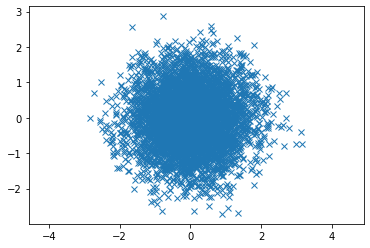

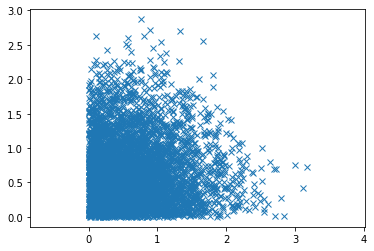

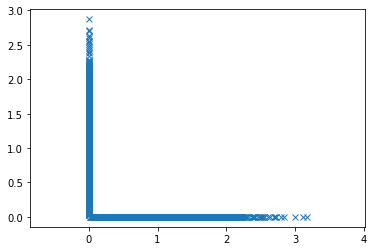

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import copy
mean = [0, 0]
cov = [[2/3, 0], [0, 2/3]]
x, y = np.random.multivariate_normal(mean, cov, 5000).T
x, y = abs(x), abs(y)

# Gen the data
a = np.random.multivariate_normal(mean, cov, 5000)
plt.plot([x[0] for x in a], [x[1] for x in a], 'x')
plt.axis('equal')
plt.show()

a = [np.absolute(x) for x in a]
plt.plot([x[0] for x in a], [x[1] for x in a], 'x')
plt.axis('equal')
plt.show()

a = np.asarray(a)
# project each value onto its maximum axis
row_maxes = a.max(axis=1).reshape(-1, 1)
a = np.where(a == row_maxes, row_maxes, 0)

plt.plot([x[0] for x in a], [x[1] for x in a], 'x')
plt.axis('equal')
plt.show()
    
def multidimsample(n, samples=1000):
    mean = [0 for i in range(n)]
    cov = [[0 if row == col else 1 for col in range(n)] for row in range(n)]
    res = np.random.multivariate_normal(mean, cov, samples)
        

In [ ]:
## OLD CODE IGNORE

# Generate the samples
    # All buckets of a given distance are incremented
    samples = {i: 0 for i in binaryStrings}
    samples2 = {i: 0 for i in binaryStrings}
    samplesLeft = sampleSize
    while samplesLeft > 0:
        s = abs(np.random.normal())
        bucketNum = s // bucket_size
        if bucketNum > maxDistance:
            bucketNum = maxDistance
        # METHOD 1
        # increment all buckets of a given bucket size (SHOULD DO THIS With CACHE)
        for bString in distances:
            dist = distances[bString]
            if dist == bucketNum:
                samples[bString] += 1
                samplesLeft -= 1 
                if samplesLeft <= 0:
                    break
    samplesLeft = sampleSize
    while samplesLeft > 0:
        s = abs(np.random.normal())
        bucketNum = s // bucket_size
        if bucketNum > maxDistance:
            bucketNum = maxDistance
        # METHOD 2:
        # Get all buckets of a given distance
        # Choose a random bucket to put the sample in
        desiredBuckets = [i for i in distances if distances[i] == bucketNum]
        samples2[random.choice(desiredBuckets)] += 1
        samplesLeft -= 1
    
    # Plot in terms of distance
    x = sorted(binaryStrings, key = lambda s: distances[s])
    y = [samples[i] for i in x]
    plt.plot(x, y)
    plt.show()
    y1 = [samples2[i] for i in x]
    plt.plot(x,y1)
    plt.show()

In [ ]:
from scipy.stats import norm
import matplotlib.pyplot as plt

norm.pdf(2)

In [15]:
paramlist2 = []
for parameter in net.parameters(): 
    paramlist2 += [parameter]
array2 = paramlist2[0].detach().numpy()
array2

array([[ 2.64369   ,  2.8064992 , -2.5737727 , -2.673256  ,  2.8192105 ,
         2.777542  , -2.7080438 , -2.8012228 ],
       [ 1.6648419 ,  1.7407252 , -0.9234456 , -0.97950256,  1.7190588 ,
         1.6905493 , -0.97223806, -1.0054615 ]], dtype=float32)

In [25]:
basis = np.matmul(array2, inv(hadamard(8)))

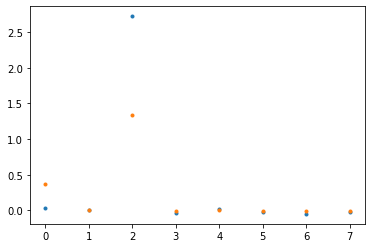

In [27]:
basis = np.matmul(array2, inv(hadamard(8)))
for a in basis: 
    plt.plot(a, '.')

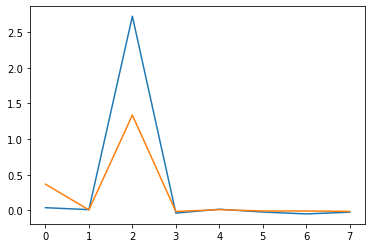

In [28]:
for a in basis:
    plt.plot(a)

In [30]:
hadamard(8)

array([[ 1,  1,  1,  1,  1,  1,  1,  1],
       [ 1, -1,  1, -1,  1, -1,  1, -1],
       [ 1,  1, -1, -1,  1,  1, -1, -1],
       [ 1, -1, -1,  1,  1, -1, -1,  1],
       [ 1,  1,  1,  1, -1, -1, -1, -1],
       [ 1, -1,  1, -1, -1,  1, -1,  1],
       [ 1,  1, -1, -1, -1, -1,  1,  1],
       [ 1, -1, -1,  1, -1,  1,  1, -1]])